# Statistical values distribution - Subcortical Volume

In [9]:
from IPython.display import display, Image
import plotly.io as pio
from pathlib import Path

force = True
anonymizer = True

root_dir = Path.cwd().parent.parent.parent

def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Root directory: {anondir(root_dir)}")
figures_dir = root_dir / "results" / "longitudinal" / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)
print(f"Figures directory: {anondir(figures_dir)}")
data_dir = root_dir / "data" 
print(f"Data directory: {anondir(data_dir)}")
results_dir = root_dir / "results" / "longitudinal"
print(f"Results directory: {anondir(results_dir)}")


# This is a static rendering of the notebook.
def show_figure(fig, width=1440, height=900):
    fig.update_layout(width=width, height=height)
    fig.show()


def write_image(fig, filename, width=1440, height=900):
    display(Image(fig.to_image(format="png", width=width, height=height, scale=2)))
    fig.write_image(
        figures_dir / filename,
        width=width,
        height=height,
        scale=2,  # Higher DPI
        engine="kaleido",
    )

Root directory: <living-park>
Figures directory: <living-park>/results/longitudinal/figures
Data directory: <living-park>/data
Results directory: <living-park>/results/longitudinal


In [10]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import plotly

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

regions = [
    "Left-Accumbens-area",
    "Right-Accumbens-area",
    "Left-Amygdala",
    "Right-Amygdala",
    "Left-Caudate",
    "Right-Caudate",
    "Left-Hippocampus",
    "Right-Hippocampus",
    "Left-Pallidum",
    "Right-Pallidum",
    "Left-Putamen",
    "Right-Putamen",
    "Left-Thalamus",
    "Right-Thalamus",
]

red = plotly.colors.qualitative.Set1[0]
ieee_marker = dict(color=red, symbol="diamond", size=10)
violin_width = 0.85
violin_jitter = 0.85

In [11]:
def get_data(test, study, ieee=False):
    if ieee:
      filename = (
        results_dir /
        (test + "_ieee") /
        f"{test}_{study}_subcortical_volume.csv"
      )
      data = pd.read_csv(filename)
      data["fs_version"] = "IEEE"
      return data
    else:
      filename = (
        data_dir /
        test /
        f"{test}_{study}_subcortical_volume.parquet"
      )
      data = pd.read_parquet(filename)
      data["significant"] = data["p-val"] < 0.05
      stat = "r" if test == "partial_correlation" else "F"
      data_avg = data.groupby("region").agg({stat: "mean", "significant": "mean"}).reset_index()    
      return data, data_avg

        
def get_preprocessed_data(test, study):
    data, data_avg = get_data(test, study)
    ieee_data = get_data(test, study, ieee=True)
    
    # Filter out the regions that are not in the data
    data = data[data["region"].isin(regions)]
    data_avg = data_avg[data_avg["region"].isin(regions)]
    ieee_data = ieee_data[ieee_data["region"].isin(regions)]
    
    # Create a position mapping dictionary
    region_to_position = {region: i for i, region in enumerate(regions)}

    # Add position columns to each dataframe
    data["position"] = data["region"].map(
        region_to_position
    )
    data_avg["position"] = data_avg["region"].map(region_to_position)
    ieee_data["position"] = ieee_data["region"].map(region_to_position)

    # Sort by position to ensure correct order
    data.sort_values(by="position", inplace=True)
    data_avg.sort_values(by="position", inplace=True)
    ieee_data.sort_values(by="position", inplace=True)
    
    return {
        "data": data,
        "data_avg": data_avg,
        "ieee_data": ieee_data,
    }    

In [12]:
def add_pcorr_baseline_trace(fig, data):
    row, col = 1, 1

    baseline_subcortical_volume = data["data"]
    baseline_subcortical_volume_avg = data["data_avg"]
    ieee_data = data["ieee_data"]

    # Use the position columns for x-axis placement
    bar_offset = -0.2  # Shift bars left
    violin_offset = 0.2  # Shift violins right

    blue = px.colors.qualitative.Plotly[4]
    green = px.colors.qualitative.D3[3]

    # Create a bar chart with offset x positions
    bar = go.Bar(
        x=baseline_subcortical_volume_avg["position"] + bar_offset,
        y=baseline_subcortical_volume_avg["significant"],
        name="Ratio",
        marker=dict(color=blue),
        showlegend=True,
        width=0.25,
        yaxis="y",
        customdata=baseline_subcortical_volume_avg["region"],
        hovertemplate="Region: %{customdata}<br>Significant Ratio: %{y:.2f}<extra></extra>",
    )

    violin = go.Violin(
        x=baseline_subcortical_volume["region"],
        y=baseline_subcortical_volume["r"],
        yaxis="y2",
        box_visible=False,
        line_color="DarkSlateGrey",
        meanline_visible=True,
        fillcolor="gray",
        opacity=0.6,
        width=violin_width,
        jitter=violin_jitter,
        showlegend=False,
        name="r coefficient",
        # spanmode="hard",
        # side='positive',
        points="all",
        pointpos=0,
        marker=dict(color="orange", opacity=1),
        customdata=baseline_subcortical_volume["region"],
        hovertemplate="Region: %{customdata}<br>r: %{y:.3f}<extra></extra>",
    )

    ieee = go.Scatter(
        x=ieee_data["region"],
        y=ieee_data["r"],
        mode="markers",
        yaxis="y2",
        marker=ieee_marker,
        showlegend=True,
        name="IEEE",
        customdata=ieee_data["region"],
        hovertemplate="Region: %{customdata}<br>r: %{y:.3f}<extra></extra>",
    )

    # fig.add_trace(bar, row=row, col=col, secondary_y=False)
    fig.add_trace(ieee, row=row, col=col)
    fig.add_trace(violin, row=row, col=col)

In [13]:
def add_pcorr_longitudinal_trace(fig, data):
    row, col = 1, 2

    longitudinal_subcortical_volume = data["data"]
    longitudinal_subcortical_volume_avg = data["data_avg"]
    ieee_data = data["ieee_data"]

    # Use the position columns for x-axis placement
    bar_offset = -0.2  # Shift bars left
    violin_offset = 0.2  # Shift violins right

    blue = px.colors.qualitative.Plotly[4]
    green = px.colors.qualitative.D3[3]

    # Create a bar chart with offset x positions
    bar = go.Bar(
        x=longitudinal_subcortical_volume_avg["position"] + bar_offset,
        y=longitudinal_subcortical_volume_avg["significant"],
        name="Ratio",
        marker=dict(color=blue),
        showlegend=False,
        width=0.25,
        yaxis="y",
        customdata=longitudinal_subcortical_volume_avg["region"],
        hovertemplate="Region: %{customdata}<br>Significant Ratio: %{y:.2f}<extra></extra>",
    )

    violin = go.Violin(
        x=longitudinal_subcortical_volume["region"],
        y=longitudinal_subcortical_volume["r"],
        yaxis="y2",
        box_visible=False,
        line_color="DarkSlateGrey",
        meanline_visible=True,
        fillcolor="gray",
        opacity=0.6,
        width=violin_width,
        jitter=violin_jitter,
        showlegend=False,
        # spanmode="hard",
        name="r coefficient",
        points="all",
        # side='positive',
        marker=dict(color="orange", opacity=1),
        pointpos=0,
        customdata=longitudinal_subcortical_volume["region"],
        hovertemplate="Region: %{customdata}<br>r: %{y:.3f}<extra></extra>",
    )

    ieee = go.Scatter(
        x=ieee_data["region"],
        y=ieee_data["r"],
        mode="markers",
        yaxis="y2",
        marker=ieee_marker,
        showlegend=False,
        name="IEEE",
        customdata=ieee_data["region"],
        hovertemplate="Region: %{customdata}<br>r: %{y:.3f}<extra></extra>",
    )

    # fig.add_trace(bar, row=row, col=col, secondary_y=False)
    fig.add_trace(ieee, row=row, col=col)
    fig.add_trace(violin, row=row, col=col)

In [14]:
def add_ancova_baseline_trace(fig, data):
    row, col = 2, 1

    baseline_subcortical_volume = data["data"]
    baseline_subcortical_volume_avg = data["data_avg"]
    ieee_data = data["ieee_data"]

    # Use the position columns for x-axis placement
    bar_offset = -0.2  # Shift bars left
    violin_offset = 0.2  # Shift violins right

    blue = px.colors.qualitative.Plotly[4]
    green = px.colors.qualitative.D3[2]

    # Create a bar chart with offset x positions
    bar = go.Bar(
        x=baseline_subcortical_volume_avg["position"] + bar_offset,
        y=baseline_subcortical_volume_avg["significant"],
        name="Ratio",
        marker=dict(color=blue),
        showlegend=False,
        width=0.25,
        yaxis="y",
        customdata=baseline_subcortical_volume_avg["region"],
        hovertemplate="Region: %{customdata}<br>Significant Ratio: %{y:.2f}<extra></extra>",
    )

    violin = go.Violin(
        x=baseline_subcortical_volume["region"],
        y=baseline_subcortical_volume["F"],
        yaxis="y2",
        box_visible=False,
        line_color="DarkSlateGrey",
        meanline_visible=True,
        fillcolor="gray",
        opacity=0.6,
        width=violin_width,
        jitter=violin_jitter,
        showlegend=False,
        marker=dict(color="orange", opacity=1),
        pointpos=0,
        name="F-value",
        spanmode="hard",
        # side='positive',
        points="all",
        customdata=baseline_subcortical_volume["region"],
        hovertemplate="Region: %{customdata}<br>F: %{y:.3f}<extra></extra>",
    )

    ieee = go.Scatter(
        x=ieee_data["region"],
        y=ieee_data["F"],
        mode="markers",
        yaxis="y2",
        marker=ieee_marker,
        showlegend=False,
        name="IEEE",
        customdata=ieee_data["region"],
        hovertemplate="Region: %{customdata}<br>F: %{y:.3f}<extra></extra>",
    )

    # fig.add_trace(bar, row=row, col=col, secondary_y=False)
    fig.add_trace(ieee, row=row, col=col)
    fig.add_trace(violin, row=row, col=col)

In [15]:
def add_ancova_longitudinal_trace(fig, data):
    row, col = 2, 2

    longitudinal_subcortical_volume = data["data"]
    longitudinal_subcortical_volume_avg = data["data_avg"]
    ieee_data = data["ieee_data"]

    # Use the position columns for x-axis placement
    bar_offset = -0.2  # Shift bars left
    violin_offset = 0.2  # Shift violins right

    blue = px.colors.qualitative.Plotly[4]
    green = px.colors.qualitative.D3[2]

    # Create a bar chart with offset x positions
    bar = go.Bar(
        x=longitudinal_subcortical_volume_avg["position"] + bar_offset,
        y=longitudinal_subcortical_volume_avg["significant"],
        name="Ratio",
        marker=dict(color=blue),
        showlegend=False,
        width=0.25,
        yaxis="y",
        customdata=longitudinal_subcortical_volume_avg["region"],
        hovertemplate="Region: %{customdata}<br>Significant Ratio: %{y:.2f}<extra></extra>",
    )

    violin = go.Violin(
        x=longitudinal_subcortical_volume["region"],
        y=longitudinal_subcortical_volume["F"],
        yaxis="y2",
        box_visible=False,
        line_color="DarkSlateGrey",
        fillcolor="gray",
        meanline_visible=False,
        pointpos=0,
        marker=dict(
            color="orange",
            opacity=1,
        ),
        width=violin_width,
        jitter=violin_jitter,
        opacity=0.6,
        showlegend=False,
        name="F-value",
        points="all",
        spanmode="hard",
        customdata=longitudinal_subcortical_volume["region"],
        hovertemplate="Region: %{customdata}<br>F: %{y:.3f}<extra></extra>",
    )

    ieee = go.Scatter(
        x=ieee_data["region"],
        y=ieee_data["F"],
        mode="markers",
        yaxis="y2",
        marker=ieee_marker,
        showlegend=False,
        name="IEEE",
        customdata=ieee_data["region"],
        hovertemplate="Region: %{customdata}<br>F: %{y:.3f}<extra></extra>",
    )

    # fig.add_trace(bar, row=row, col=col, secondary_y=False)
    fig.add_trace(ieee, row=row, col=col)
    fig.add_trace(violin, row=row, col=col)

## Consistency of Statistically Significant Regions

This analysis quantifies the consistency of statistically significant findings across different brain regions. For each region, we compute the proportion of statistical tests that yield significant results relative to the total number of tests performed. 

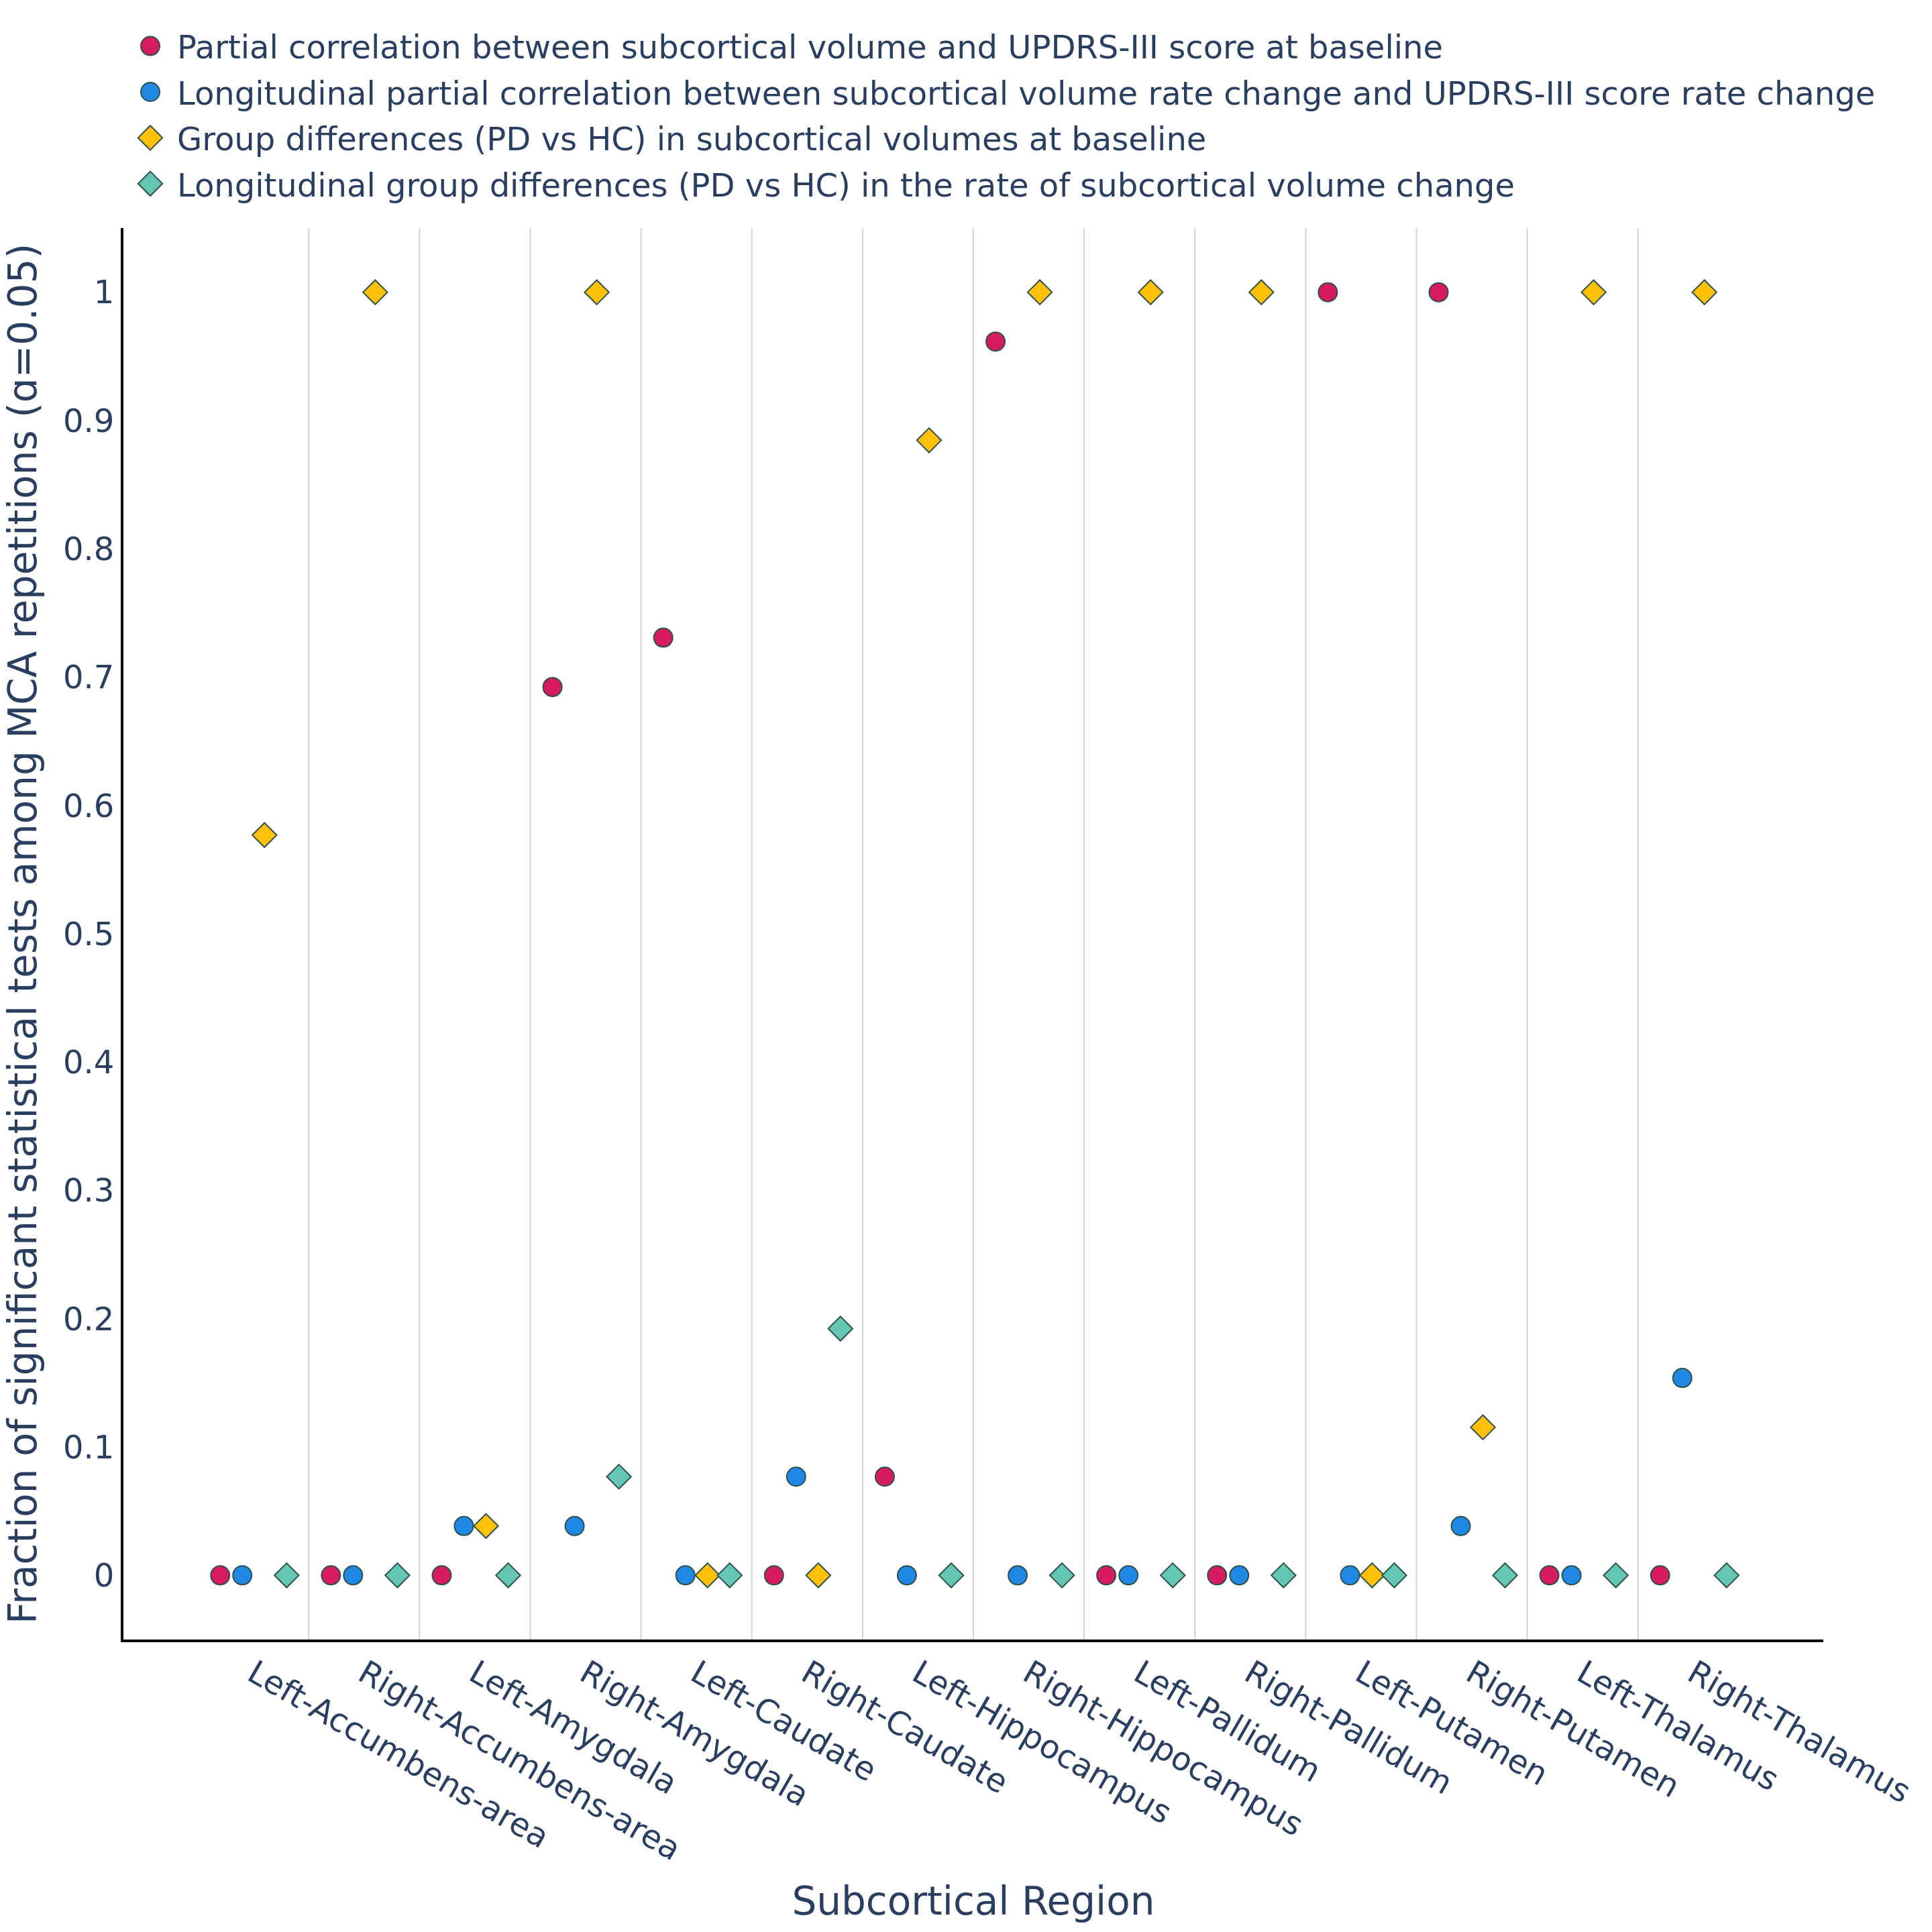

In [16]:
pcorr_baseline_subcortical_volume_avg = get_preprocessed_data("partial_correlation", "baseline")["data_avg"]
pcorr_longitudinal_subcortical_volume_avg = get_preprocessed_data("partial_correlation", "longitudinal")[
    "data_avg"
]   
ancova_baseline_subcortical_volume_avg = get_preprocessed_data("ancova", "baseline")[
    "data_avg"
]
ancova_longitudinal_subcortical_volume_avg = get_preprocessed_data("ancova", "longitudinal")[
    "data_avg"
]

fig = go.Figure()

colormap = px.colors.qualitative.Plotly
# colorblind palette: blue, red, green, yellow
colormap = ["#D81B60", "#1E88E5", "#FFC107", "#63C7B3"]
marker_size = 14
symbol_pcorr = "circle"
symbol_ancova = "diamond"
marker_line = dict(width=1, color="DarkSlateGrey")


def get_jittered_positions(length, jitter_amount):
    # Generate random jitter for x-axis positions
    # jit = np.random.uniform(-jitter_amount, jitter_amount, length)
    return [x + jitter_amount for x in range(length)]


# Create the scatter plot with jitter
pcorr_base = go.Scatter(
    x=get_jittered_positions(
        pcorr_baseline_subcortical_volume_avg["region"].shape[0], -0.3
    ),
    y=pcorr_baseline_subcortical_volume_avg["significant"],
    mode="markers",
    marker=dict(
        color=colormap[0], size=marker_size, symbol=symbol_pcorr, line=marker_line
    ),
    name="Partial correlation between subcortical volume and UPDRS-III score at baseline",
    text=pcorr_baseline_subcortical_volume_avg[
        "region"
    ],  # Store original region names as hover text
)

pcorr_long = go.Scatter(
    x=get_jittered_positions(
        pcorr_longitudinal_subcortical_volume_avg["region"].shape[0], -0.1
    ),
    y=pcorr_longitudinal_subcortical_volume_avg["significant"],
    mode="markers",
    marker=dict(
        color=colormap[1], size=marker_size, symbol=symbol_pcorr, line=marker_line
    ),
    name="Longitudinal partial correlation between subcortical volume rate change and UPDRS-III score rate change",
)

ancova_base = go.Scatter(
    x=get_jittered_positions(
        ancova_baseline_subcortical_volume_avg["region"].shape[0], 0.1
    ),
    y=ancova_baseline_subcortical_volume_avg["significant"],
    mode="markers",
    marker=dict(
        color=colormap[2], size=marker_size, symbol=symbol_ancova, line=marker_line
    ),
    name="Group differences (PD vs HC) in subcortical volumes at baseline",
)

ancova_long = go.Scatter(
    x=get_jittered_positions(
        ancova_longitudinal_subcortical_volume_avg["region"].shape[0], 0.3
    ),
    y=ancova_longitudinal_subcortical_volume_avg["significant"],
    mode="markers",
    marker=dict(
        color=colormap[3], size=marker_size, symbol=symbol_ancova, line=marker_line
    ),
    name="Longitudinal group differences (PD vs HC) in the rate of subcortical volume change",
)

fig.add_trace(pcorr_base)
fig.add_trace(pcorr_long)
fig.add_trace(ancova_base)
fig.add_trace(ancova_long)

fig.update_xaxes(
    title="Subcortical Region",
    tickmode="array",
    tickvals=list(range(len(pcorr_baseline_subcortical_volume_avg["region"]))),
    ticktext=pcorr_baseline_subcortical_volume_avg["region"],
)
fig.update_yaxes(
    title="Fraction of significant statistical tests among MCA repetitions (ɑ=0.05)",
    range=[-0.05, 1.05],
    dtick=0.1,
)


# Position legend within grid top-left
fig.update_layout(
    legend=dict(
        x=0.0,
        y=1.15,
        xanchor="left",
        yanchor="top",
        orientation="h",
        bgcolor="rgba(255, 255, 255, 0)",
    )
)

background_color = "White"
fig.update_layout(
    plot_bgcolor=background_color,
    paper_bgcolor=background_color,
    # margin=dict(l=20, r=20, t=50, b=20),
)

grid_color = "LightGray"

# Turn off default grid lines
fig.update_xaxes(
    gridcolor=grid_color,
    gridwidth=1,
    zeroline=False,
    showgrid=False,  # Turn off default grid
    showline=True,
    linewidth=2,
    linecolor="black",
)
fig.update_yaxes(
    gridcolor=grid_color,
    gridwidth=1,
    zeroline=False,
    showgrid=False,
    showline=True,
    linewidth=2,
    linecolor="black",
)

# Add custom vertical grid lines positioned between cortical regions
for i in range(len(regions) - 1):
    fig.add_vline(x=i + 0.5, line=dict(color=grid_color, width=1), layer="below")

# Increase font size
fig.update_layout(font=dict(size=24))

write_image(
    fig, "subcortical_volume_significance_correlation.pdf", width=1440, height=1440
)
show_figure(fig, width=1440, height=1440)

## Distribution of Statistical Values

Distribution of statistical values, specifically the correlation coefficients (r) from partial correlation analyses and the F-values from ANCOVA tests.

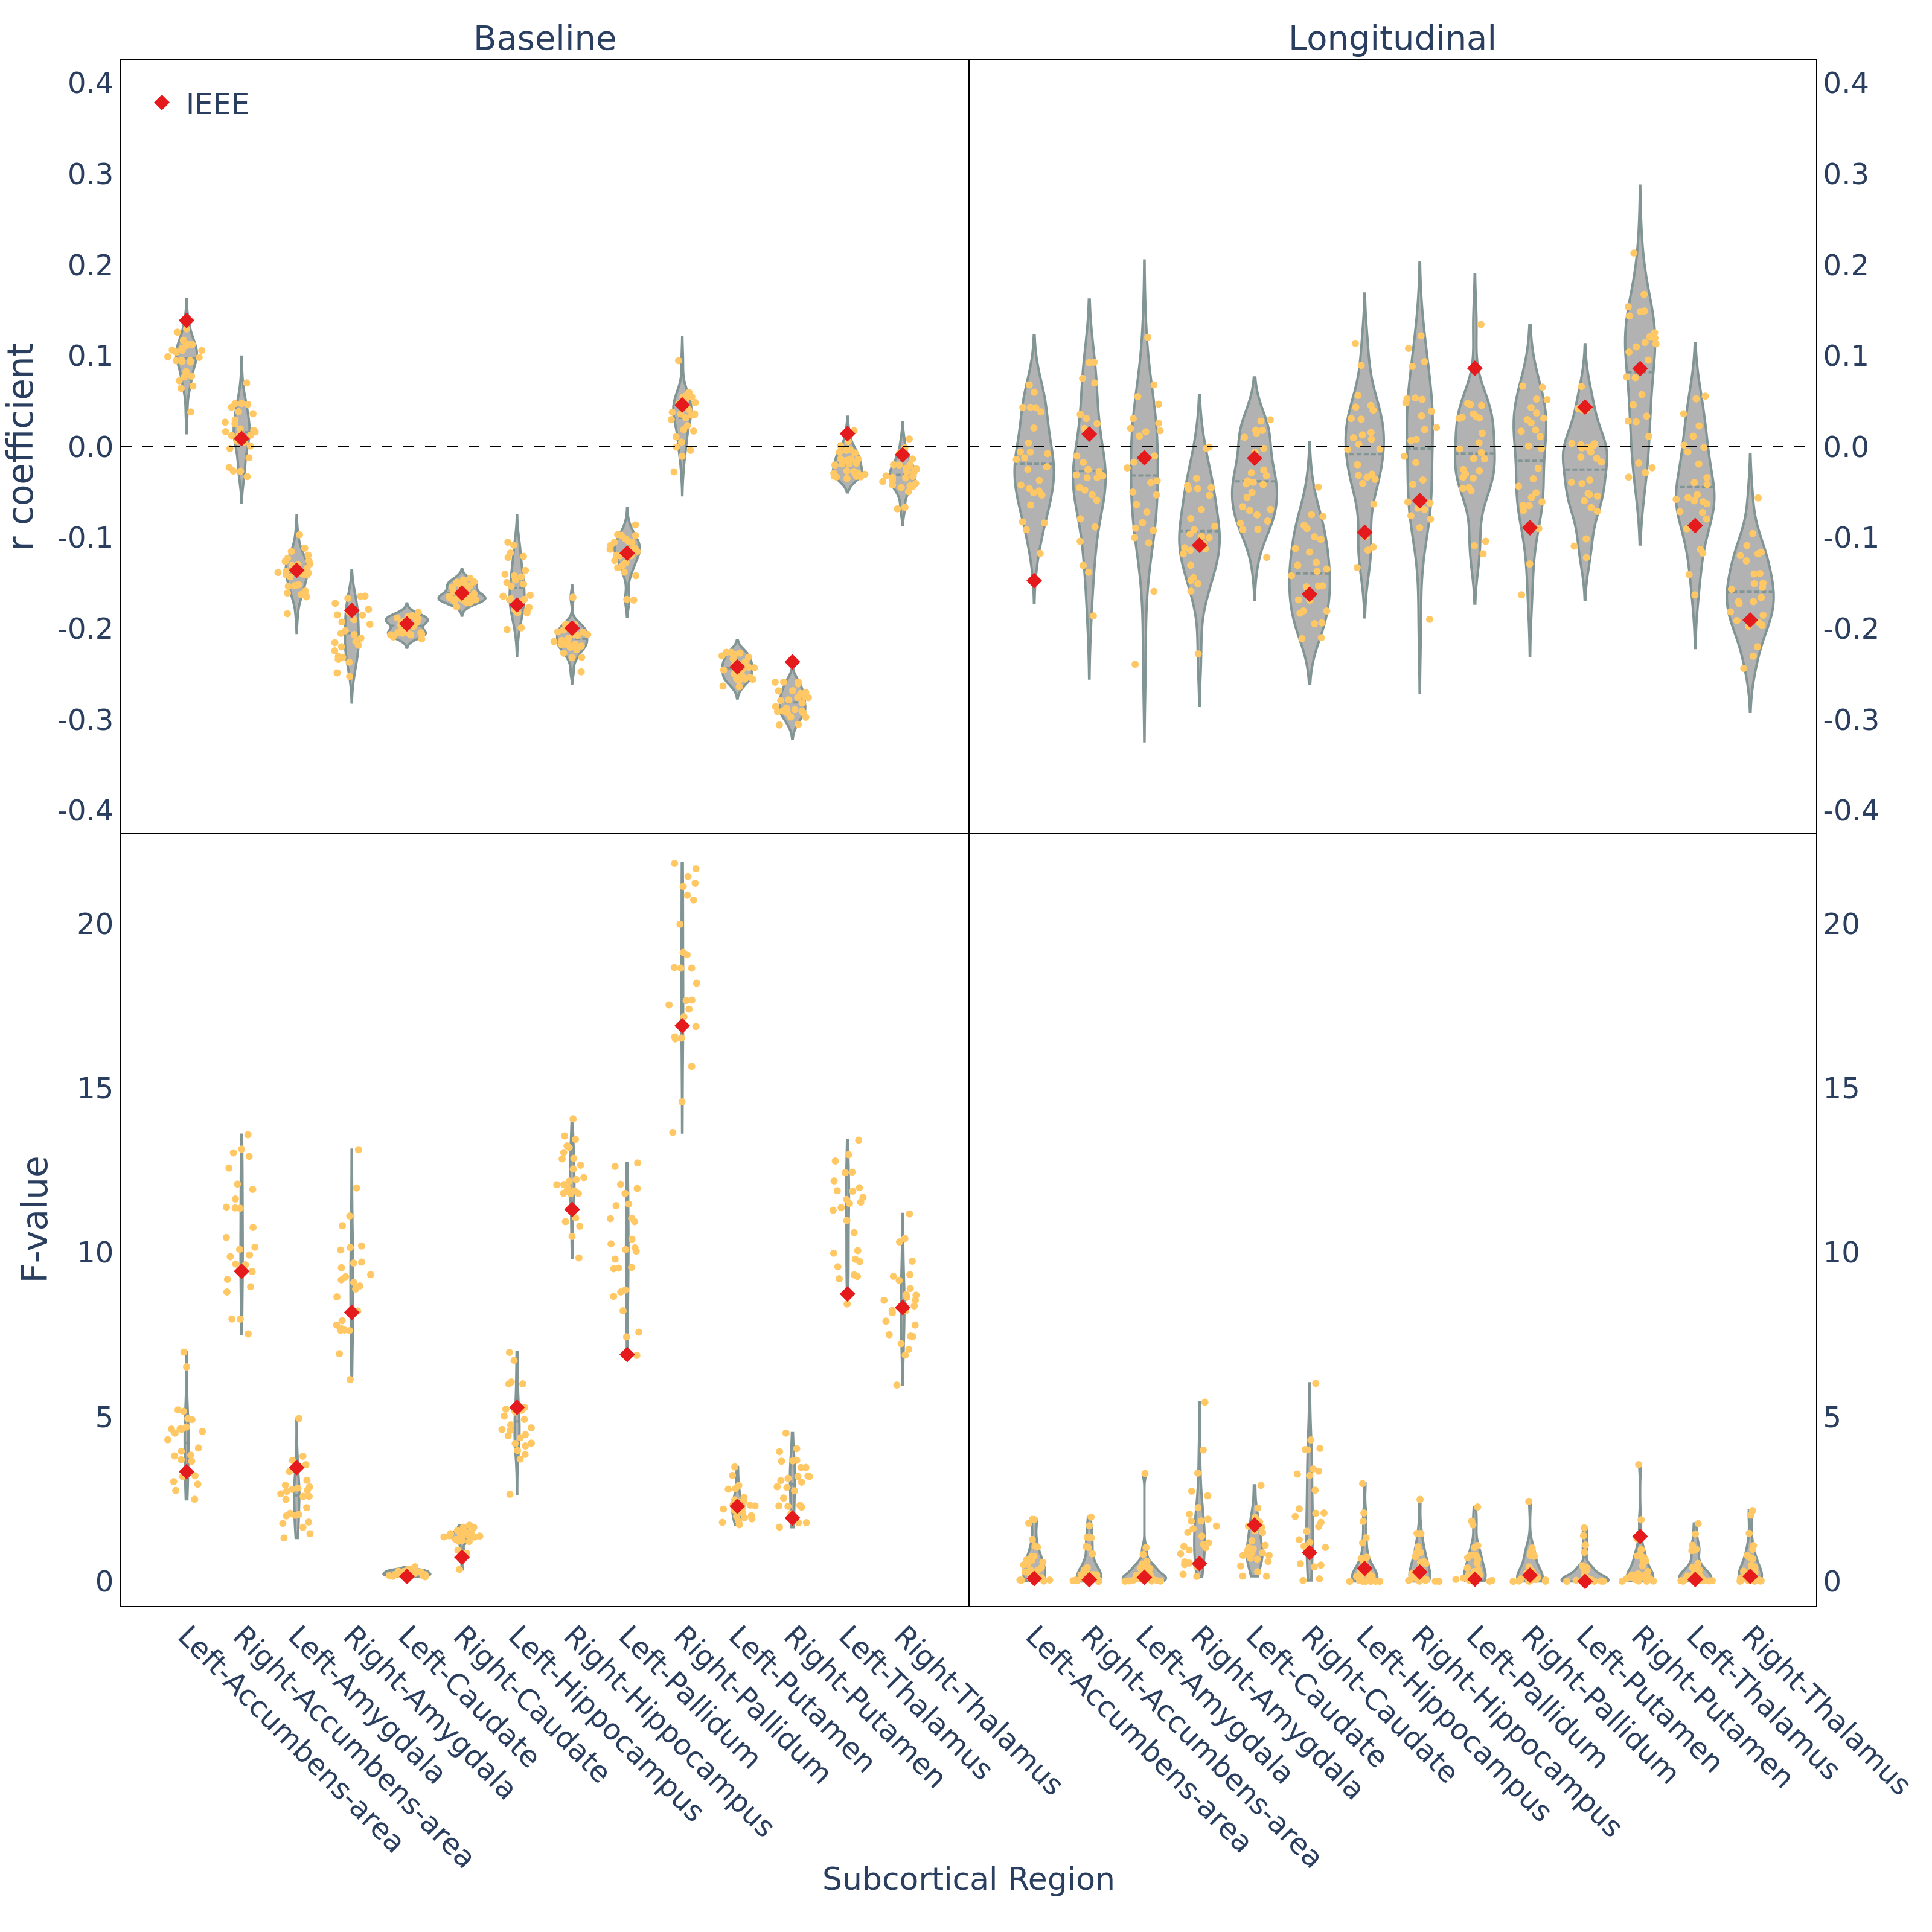

In [17]:
from plotly.subplots import make_subplots

# Create subplots with 2 rows and 2 columns
fig = make_subplots(
    rows=2,
    cols=2,
    shared_xaxes=True,
    column_titles=["Baseline", "Longitudinal"],
    x_title="Subcortical Region",
    vertical_spacing=0,
    horizontal_spacing=0,
)


# Add traces to the subplots
add_pcorr_baseline_trace(fig, get_preprocessed_data("partial_correlation", "baseline"))
add_pcorr_longitudinal_trace(fig, get_preprocessed_data("partial_correlation", "longitudinal"))
add_ancova_baseline_trace(fig, get_preprocessed_data("ancova", "baseline"))
add_ancova_longitudinal_trace(fig, get_preprocessed_data("ancova", "longitudinal"))

# Set x-axis ticks and labels
fig.update_xaxes(
    title_text="", tickvals=list(range(len(regions))), ticktext=regions, tickangle=45
)

yaxis_r_range = [-0.425, 0.425]
yaxis_r_tickvals = np.arange(-0.5, 0.6, 0.1)
yaxis_r_tickvals = [
    0 if np.isclose(x, 0) else x for x in yaxis_r_tickvals
]  # Replace 0 with 0.0
yaxis_r_ticktext = [
    "0.0" if np.isclose(x, 0) else str(round(x, 1)) for x in yaxis_r_tickvals
]
yaxis_r_clear = ["" for x in yaxis_r_tickvals]

yaxis_f_range = [-0.75, 22.75]
yaxis_f_tickvals = [0, 10, 20, 30, 40, 50]
yaxis_f_ticktext = ["0", "10", "20", "30", "40", "50"]
yaxis_f_clear = ["" for x in yaxis_f_tickvals]

# Update layout for all axes
fig.update_layout(
    # Primary y-axes (left side, 0 to 1)
    yaxis1=dict(
        title="r coefficient",
        range=yaxis_r_range,
        dtick=0.1,
        showgrid=False,
        # dashed bold the 0 line
        zeroline=False,
        zerolinewidth=2,
        zerolinecolor="DarkSlateGrey",
        tickvals=yaxis_r_tickvals,
        ticktext=yaxis_r_ticktext,
    ),
    yaxis2=dict(
        dtick=0.1,
        showgrid=False,
        range=yaxis_r_range,
        zeroline=False,
        zerolinewidth=2,
        zerolinecolor="black",
        tickvals=yaxis_r_tickvals,
        ticktext=yaxis_r_ticktext,
        side="right",
    ),
    yaxis3=dict(
        title="F-value",
        range=yaxis_f_range,
        showgrid=False,
        zeroline=False,
    ),
    yaxis4=dict(showgrid=False, zeroline=False, range=yaxis_f_range, side="right"),
    # Other layout settings
    legend=dict(
        x=0.01,
        y=0.99,
        orientation="h",
        yanchor="top",
        xanchor="left",
        bgcolor="rgba(255, 255, 255, 0)",
    ),
    margin=dict(t=50, b=150, r=20),
    # margin=dict(b=150,
    #             l=150)  # Add bottom margin for tilted labels
    plot_bgcolor=background_color,
    paper_bgcolor=background_color,
)

fig.add_hline(
    y=0,
    row=1,
    line_color="black",
    line_width=1,
    line_dash="dash",
)


# Update each axis individually
fig.update_layout(
    xaxis1=dict(showline=True, linewidth=1, linecolor="black", mirror=True),
    xaxis2=dict(showline=True, linewidth=1, linecolor="black", mirror=True),
    xaxis3=dict(showline=True, linewidth=1, linecolor="black", mirror=False),
    xaxis4=dict(showline=True, linewidth=1, linecolor="black", mirror=False),
    yaxis1=dict(showline=True, linewidth=1, linecolor="black", mirror=True),
    yaxis2=dict(showline=True, linewidth=1, linecolor="black", mirror=False),
    yaxis3=dict(showline=True, linewidth=1, linecolor="black", mirror=True),
    yaxis4=dict(showline=True, linewidth=1, linecolor="black", mirror=False),
)

fig.update_layout(font_family="Helvetica", font_size=24)
fig.update_annotations(font=dict(family="Helvetica", size=24))

# Update y position of annotation with "subcortical region" text
for annotation in fig.layout.annotations:
    if annotation.text.lower() == "subcortical region":
        annotation.y = -0.14  # Adjust this value as needed for better positioning
        annotation.font.size = 26

# Update font size for Baseline and Longitudinal titles
for annotation in fig.layout.annotations:
    if annotation.text in ["Baseline", "Longitudinal"]:
        annotation.font.size = 28  # Set the desired font size for these titles

# Optional: Make corner borders more prominent
fig.update_layout(
    plot_bgcolor=background_color,
    paper_bgcolor=background_color,
)

write_image(
    fig, "subcortical_volume_coefficients_distribution.pdf", width=1600, height=1600
)
show_figure(fig, width=1600, height=1600)